In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_violin, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.1, 0.7]

## The model

In [2]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami

## Sobol indices with a classical Monte-Carlo sampling

In [3]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 500

# Evaluate the model
sobol = SobolIndices(model.input_distribution)
sobol.build_mc_sample(model=model, n_sample=n_sample)

In [4]:
n_boot = 1000
estimator = 'sobol2007'

# Indice estimatino
sobol_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_results.true_indices = ishigami.indices

# Results
first_indices_mc = sobol_results.first_indices
total_indices_mc = sobol_results.total_indices

print("Sobol indices:", first_indices_mc)
print("Total Sobol indices:", total_indices_mc)

Sobol indices: [ 0.3880958   0.4860795   0.01192895]
Total Sobol indices: [ 0.57713344  0.44460754  0.38119865]


Let's see how it looks like in the plot

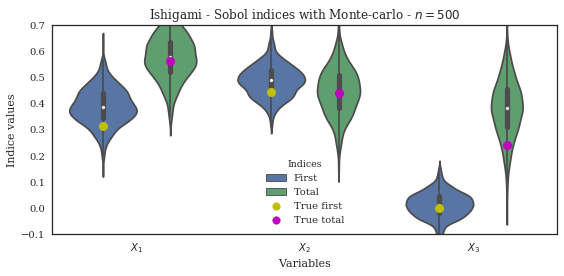

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_results, ax=ax)
ax.set_title("Ishigami - Sobol indices with Monte-carlo - $n=%d$" % (n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_MC.pdf')

## Using a Kriging model to substitute the true model

### Building the model

In [6]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 100
basis = 'quadratic'
kernel = 'exponential'
library = 'OT'
sobol_kriging = SobolKrigingIndices(model.input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library)

### The quality of the kriging model

#### With Leave One Out

In [7]:
if library == 'OT' and False:
    score_q2_loo = meta_model.compute_score_q2_loo()
    print('Leave One Out Q2 score:', score_q2_loo)

#### With cross validation

In [8]:
n_sample_cv = 1000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='lhs')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 1000 observations: 0.743380406563


### Estimating the indices

In [9]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 500
n_realization = 300

# Evaluate the kriging model
sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization)

Wall time: 20.8 s


In [10]:
%%time
n_boot = 500
estimator = 'soboleff2'
sobol_kriging_results = sobol_kriging.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_kriging_results.true_indices = ishigami.indices

# Results
first_indices_gp = sobol_kriging_results.first_indices
total_indices_gp = sobol_kriging_results.total_indices

print("Sobol indices:", first_indices_gp)
print("Total Sobol indices:", total_indices_gp)

Sobol indices: [ 0.27460545  0.32300132  0.03155173]
Total Sobol indices: [ 0.66046336  0.75511473  0.38819004]
Wall time: 11.6 s


#### Plot with the first and total indices

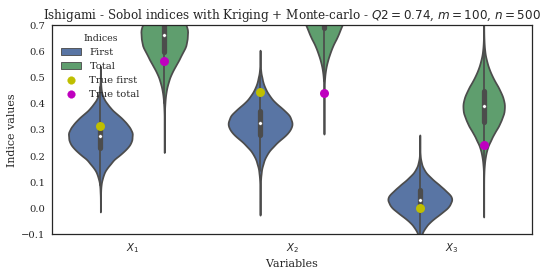

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_kriging_results, indice='both', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_GP.pdf')

#### Plots of the first indices with the kriging and monte-carlo errors

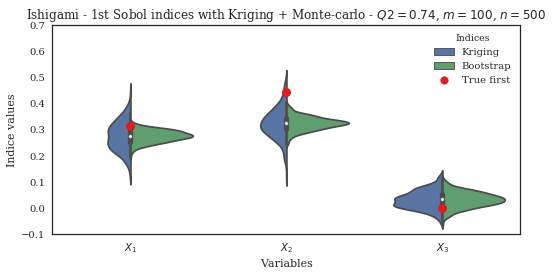

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - 1st Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_GP.pdf')

#### Plots of the total indices with the kriging and monte-carlo errors

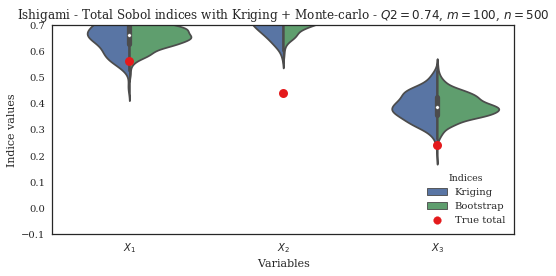

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - Total Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_total_sobol_GP.pdf')